# Convolve and resample with PyTorch and Kornia

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

In [3]:
import kornia

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from blase.multiorder import MultiOrder
from blase.datasets import HPFDataset

In [6]:
device = 'cpu'

In [7]:
data = HPFDataset('../test/data/Goldilocks_20191022T013208_v1.0_0003.spectra.fits')

In [8]:
obs = data.data_cube

In [9]:
model = MultiOrder(device=device, wl_data=obs[6, :, :])

In [10]:
%time model.forward(0).detach()

CPU times: user 905 ms, sys: 201 ms, total: 1.11 s
Wall time: 185 ms


tensor([0.6913, 0.7153, 0.7175,  ..., 1.3111, 1.3269, 1.2611],
       dtype=torch.float64)

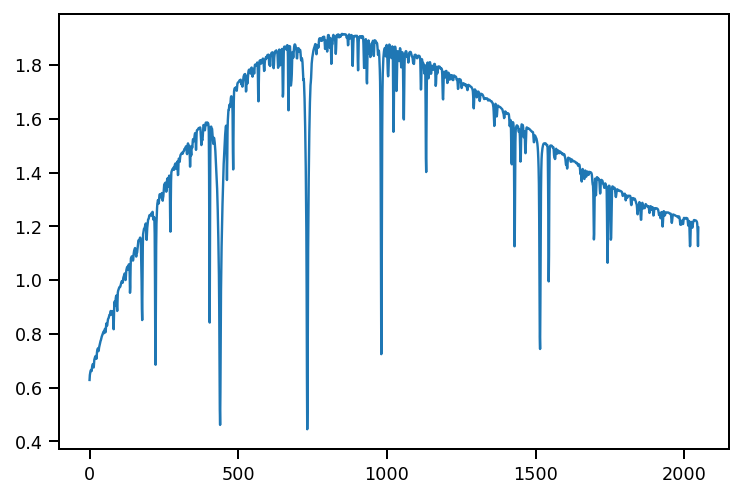

In [17]:
plt.plot(model.forward(6).detach())

In [16]:
import torch

In [17]:
vec = torch.arange(10.0)

In [18]:
torch.nanmedian(vec)

AttributeError: module 'torch' has no attribute 'nanmedian'

In [15]:
data.data_cube

tensor([[[       nan,        nan,        nan,  ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan,  ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan,  ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan,  ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan,  ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan,  ...,        nan,
                 nan,        nan]],

        [[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         ...,
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0

In [14]:
model.flux_native

tensor([1.3022, 1.3038, 1.3042,  ..., 0.6900, 0.6908, 0.6912],
       dtype=torch.float64)

Text(0.5, 1.0, 'Native Resolution')

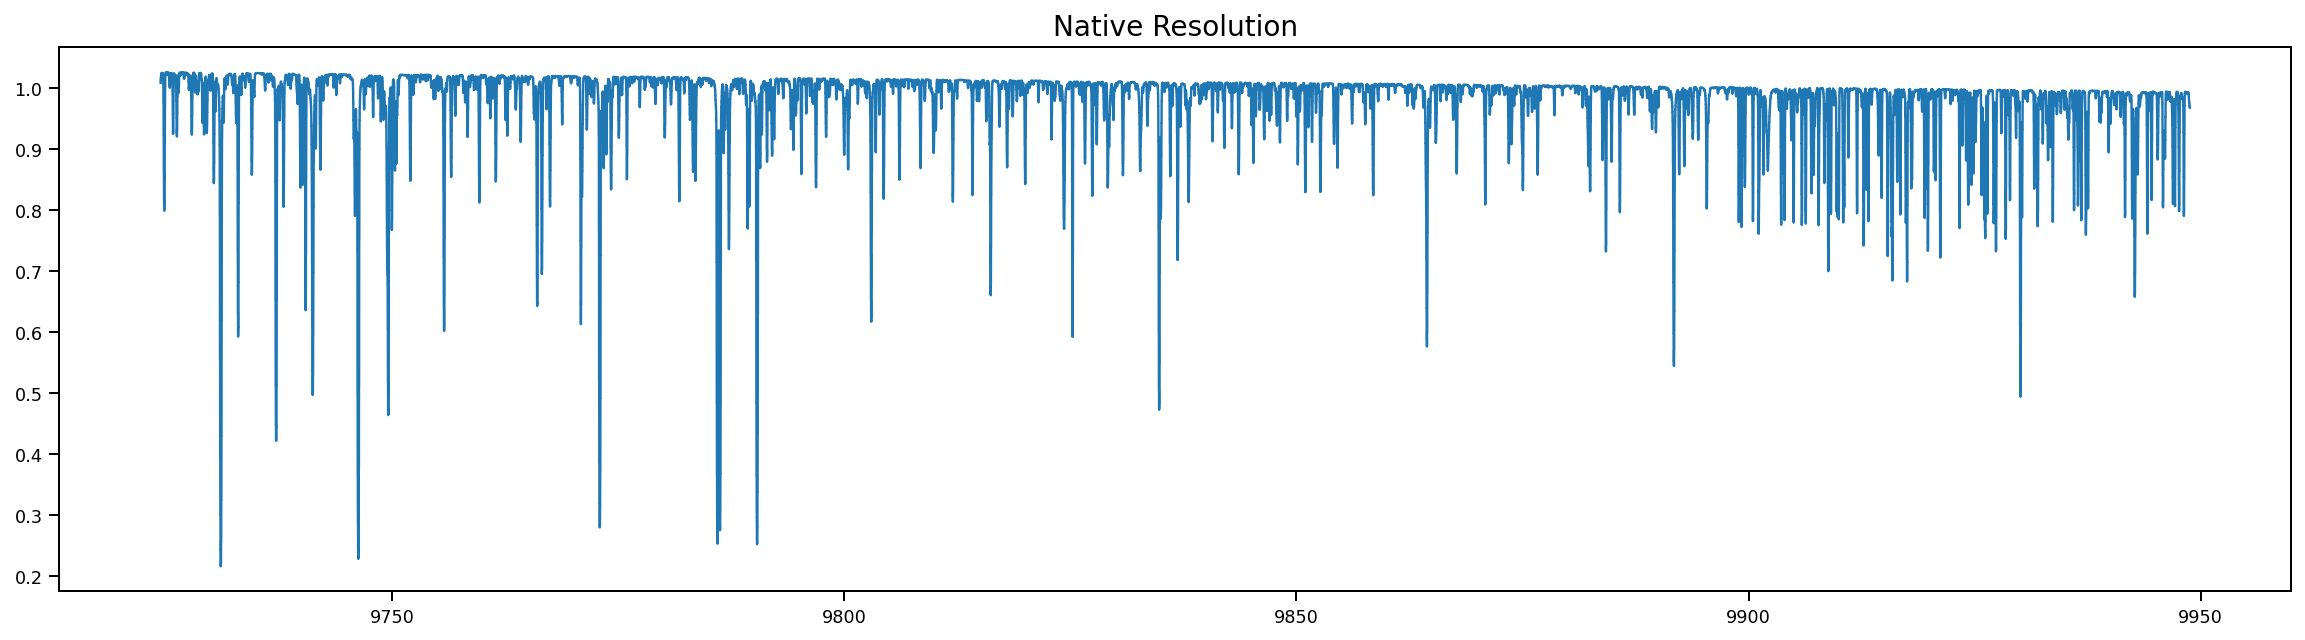

In [13]:
plt.figure(figsize=(20, 5))
plt.step(model.wl_native.numpy(), model.flux_native.numpy())
plt.title('Native Resolution', fontsize=14)

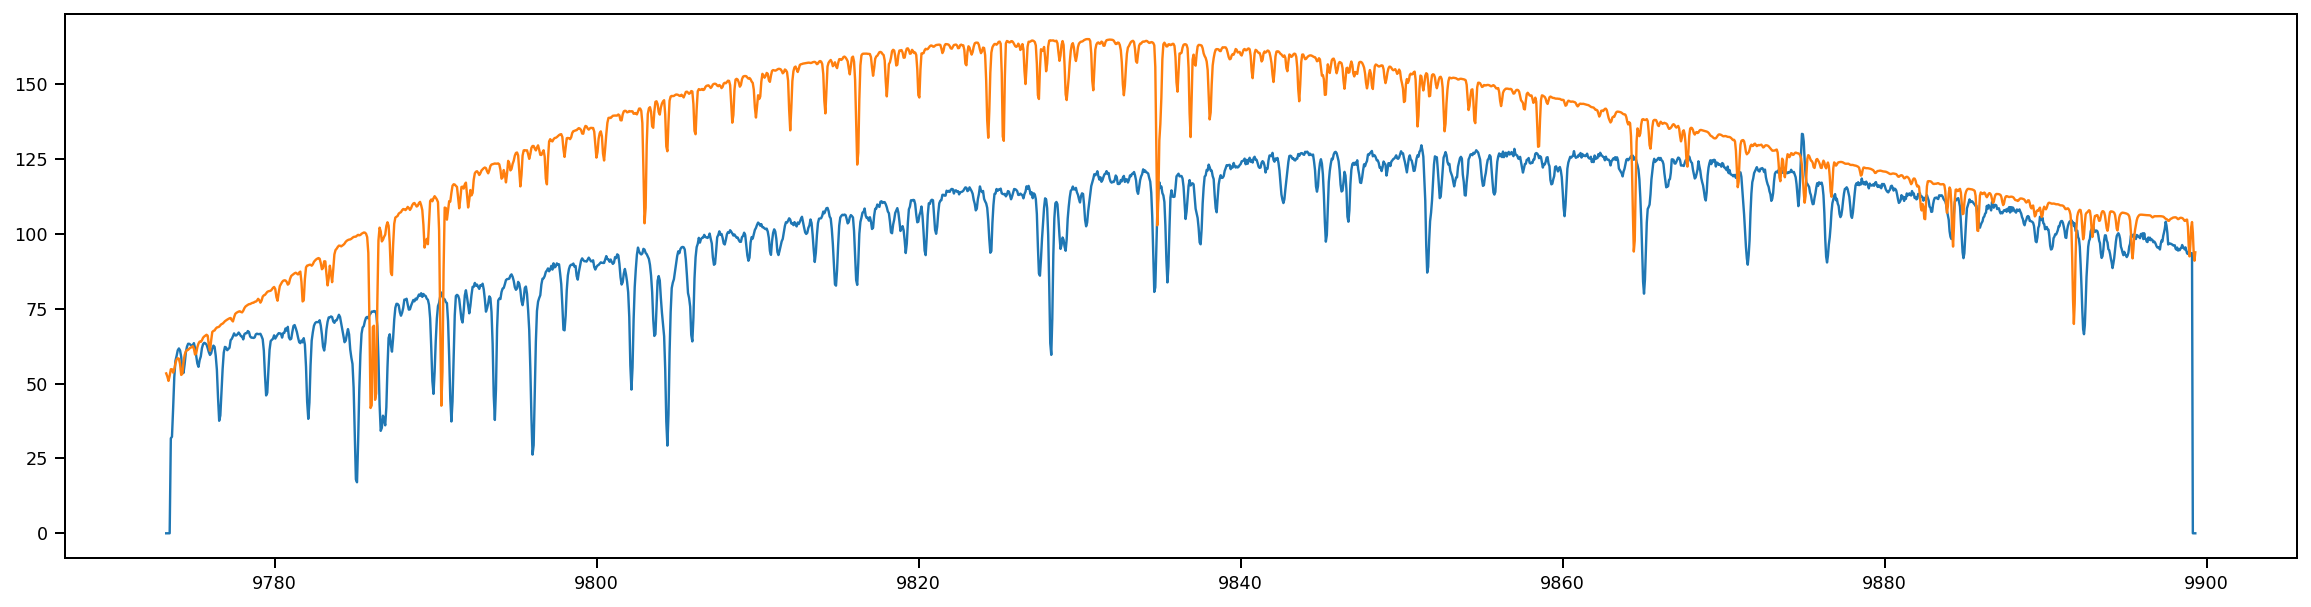

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(obs[6, 13, :],obs[0, 13, :]);
plt.plot(model.wl_data, model.forward().detach()*100);

In [46]:
import torch

In [63]:
xv = torch.linspace(-1, 1, 2048)

coeffs = torch.tensor([1.2, 0.1, -0.4, 0.15])

cheb_array = torch.stack([torch.ones(2048), xv, 2*xv**2-1, 4*xv**3-3*xv])

In [69]:
blaze = (cheb_array * coeffs.unsqueeze(1)).sum(0)

In [70]:
blaze.shape

torch.Size([2048])

In [43]:
residual = obs[0, 13, :] - model.forward().detach()

In [44]:
residual

tensor([-194.3070, -189.4959, -183.2426,  ..., -178.9722, -173.4837,
        -178.8418], dtype=torch.float64)

In [12]:
sm_flux = kornia.filters.gaussian_blur2d(flux_native.view(1,1,1,-1), kernel_size=(1, 71), sigma=(0.01, 5.35)).squeeze()

(10820.0, 10840.0)

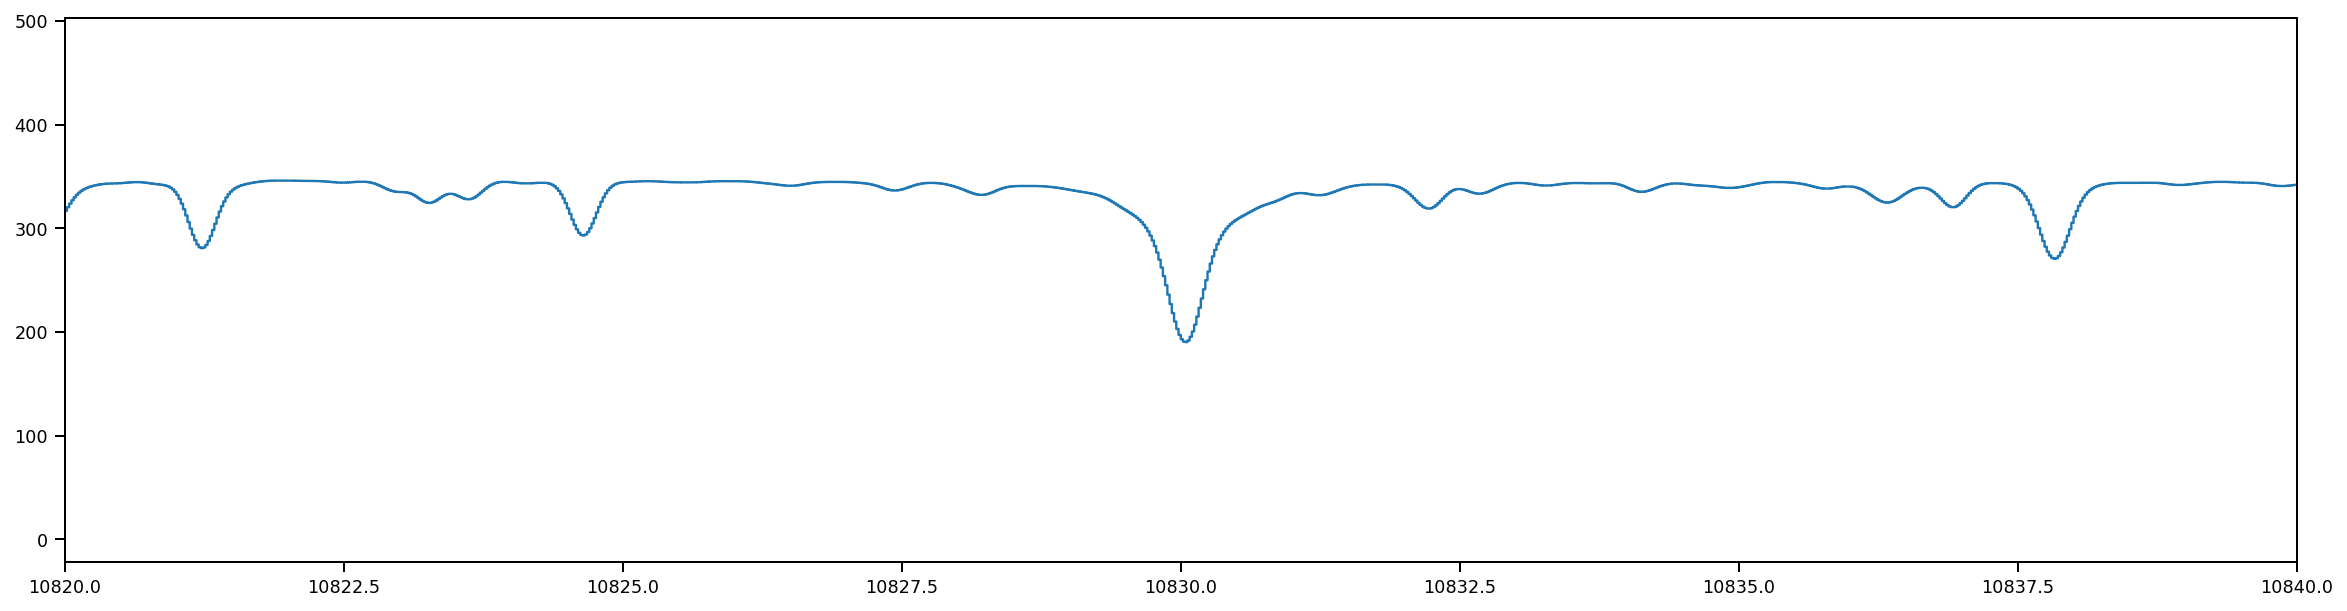

In [13]:
plt.figure(figsize=(20, 5))
plt.step(model.wl_native.numpy(), sm_flux.numpy())
plt.xlim(10820, 10840)

In [16]:
data.hdus.info()

Filename: ../test/data/Goldilocks_20191022T013208_v1.0_0003.spectra.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     317   ()      
  1  Sci Flux      1 ImageHDU         8   (2048, 28)   float32   
  2  Sky Flux      1 ImageHDU         8   (2048, 28)   float32   
  3  Cal Flux      1 ImageHDU         8   (2048, 28)   float32   
  4  Sci Error     1 ImageHDU         8   (2048, 28)   float32   
  5  Sky Error     1 ImageHDU         8   (2048, 28)   float32   
  6  Cal Error     1 ImageHDU         8   (2048, 28)   float32   
  7  Sci Wavl      1 ImageHDU         8   (2048, 28)   float64   
  8  Sky Wavl      1 ImageHDU         8   (2048, 28)   float64   
  9  Cal Wavl      1 ImageHDU         8   (2048, 28)   float64   


In [18]:
wl, flux, unc = data[0]

Get the data wavelength vector for a single order

In [98]:
wl

tensor([9773.2687, 9773.3404, 9773.4121,  ..., 9899.1808, 9899.2317,
        9899.2825], dtype=torch.float64)

In [61]:
wl = data.data_cube[6, 13, :]
flux_data = data.data_cube[0, 13, :]

In [28]:
x = wl.unsqueeze(1).cuda()
trim_mask = (model.wl_native > wl[0]) &  (model.wl_native < wl[-1])
y = model.wl_native[trim_mask].unsqueeze(0).cuda()

In [29]:
dist = (x-y)**2

In [44]:
indices = dist.argmin(0)

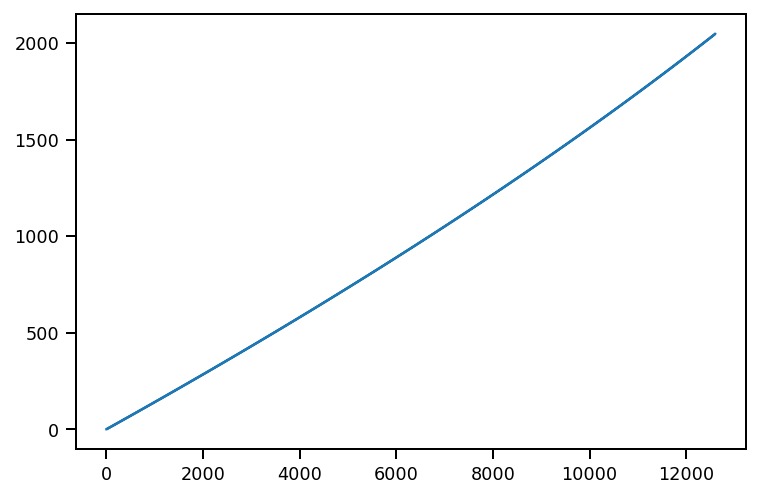

In [37]:
plt.plot(dist.argmin(0).cpu())

In [68]:
model_flux = sm_flux[trim_mask].detach()

In [69]:
import torch

In [70]:
idx, vals = torch.unique(indices, return_counts=True)

In [71]:
vs = torch.split_with_sizes(model_flux, tuple(vals))

In [72]:
#d1 = {k.item():v for k,v in zip(idx, vs)}

In [73]:
resampled_model_flux = torch.tensor([v.mean() for v in vs])

In [74]:
resampled_model_flux.shape

torch.Size([2048])

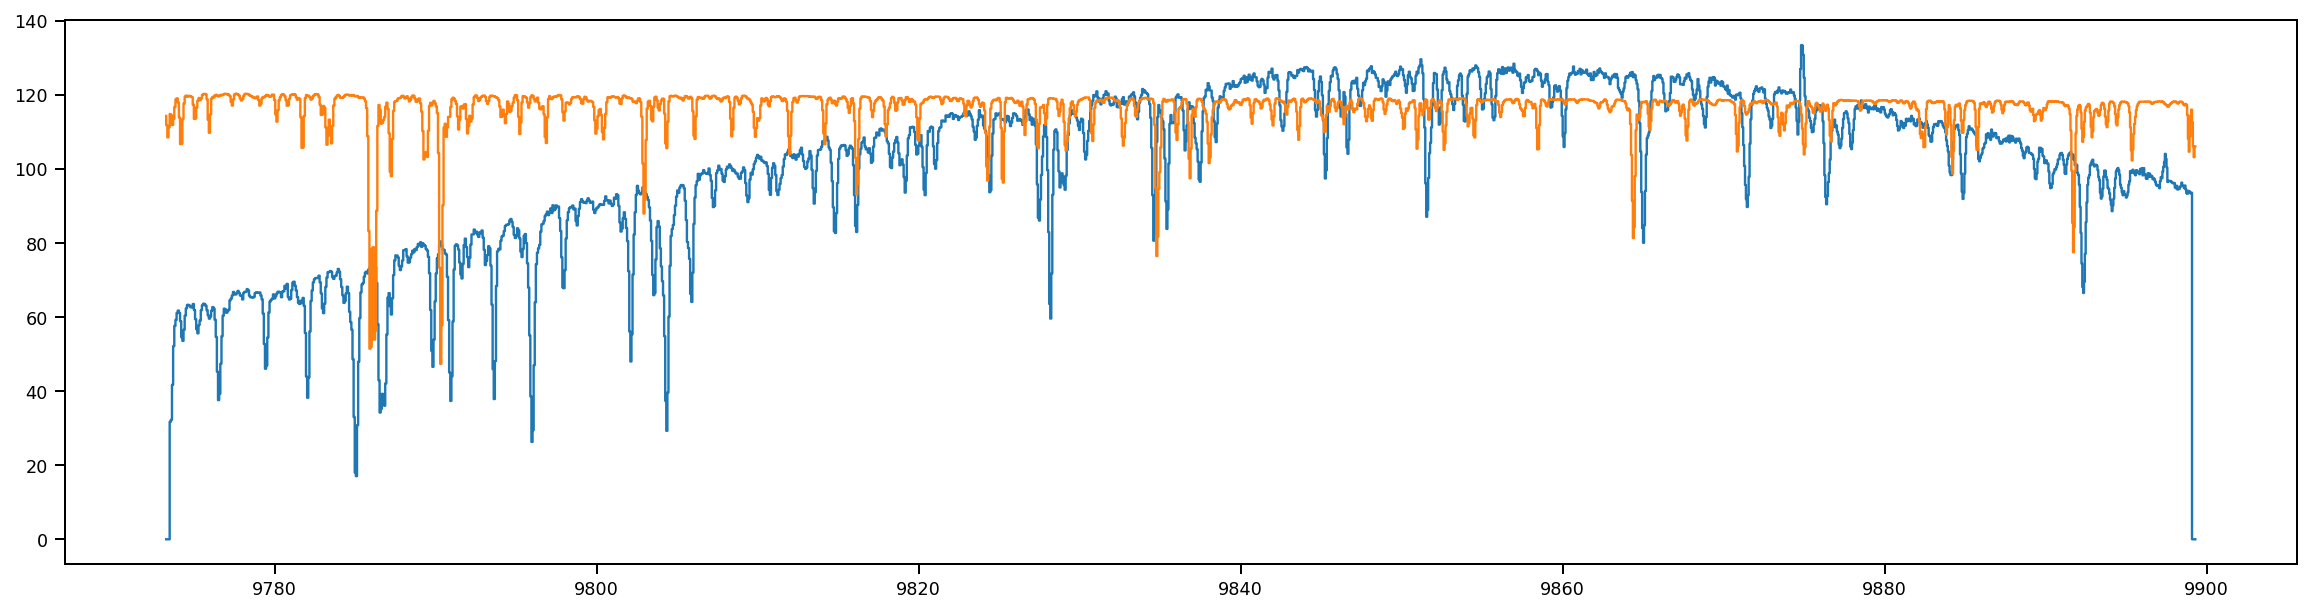

In [78]:
plt.figure(figsize=(20, 5))
plt.step(wl, flux_data)
plt.step(wl, resampled_model_flux*0.3)

In [76]:
model_flux.max()

tensor(401.2330, dtype=torch.float64)

In [19]:
hdus = data.hdus

In [15]:
import torch

In [16]:
n_slices = 9

In [21]:
data_cube = torch.tensor([])#torch.zeros(2048, 28, n_slices, dtype=torch.float64)

In [42]:
data_cube = []
for i in range(1, n_slices + 1):
    data_cube.append(hdus[i].data.astype(np.float64))

In [43]:
data_cube = torch.tensor(data_cube)

In [45]:
data_cube.shape

torch.Size([9, 28, 2048])

In [46]:
data_cube[0, :,:]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [ ]:
cube = torch.ten

In [15]:
data.order

tensor([ 0,  0,  0,  ..., 27, 27, 27], device='cuda:0', dtype=torch.int16)

In [66]:
wl, flux, unc = data[0]

In [67]:
wl, flux, unc = wl.to(device), flux.to(device), unc.to(device)

First do the radial velocity:

In [81]:
import torch

In [82]:
c_km_s = torch.tensor(2.99792458e5)

In [93]:
vz = torch.tensor(1200.0) # km/s

In [94]:
rv_shift = torch.sqrt((c_km_s + vz) / (c_km_s -vz))

In [95]:
1/rv_shift

tensor(0.9960)

(10820.0, 10840.0)

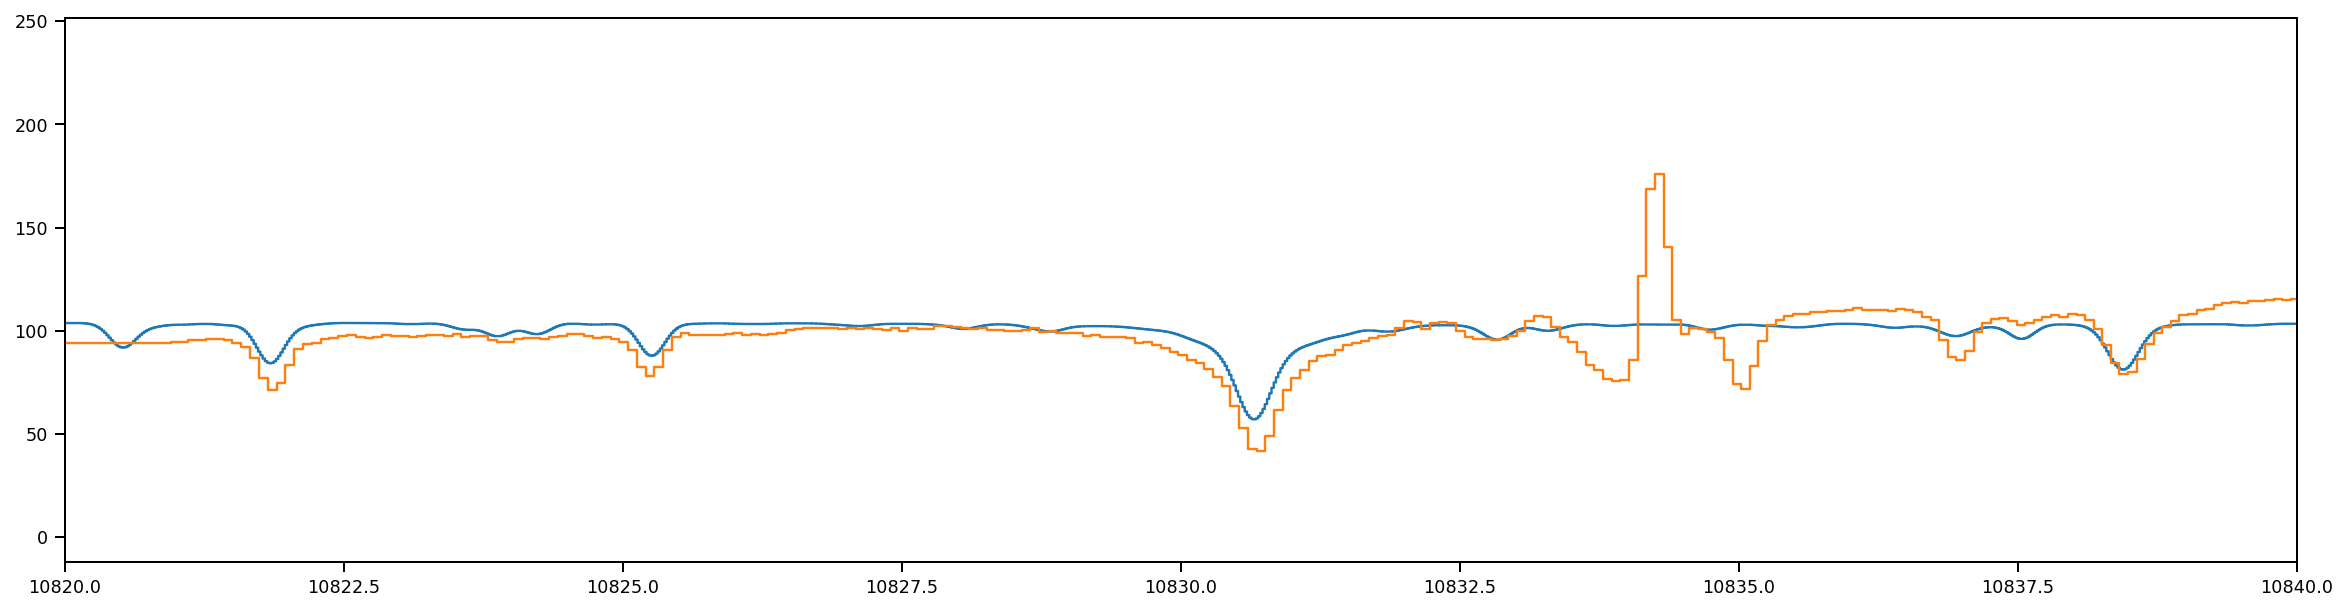

In [75]:
plt.figure(figsize=(20, 5))
plt.step((model.wl_native*rv_shift).numpy(), sm_flux.numpy()*0.3)
plt.step(wl, flux)
plt.xlim(10820, 10840)

Resample:

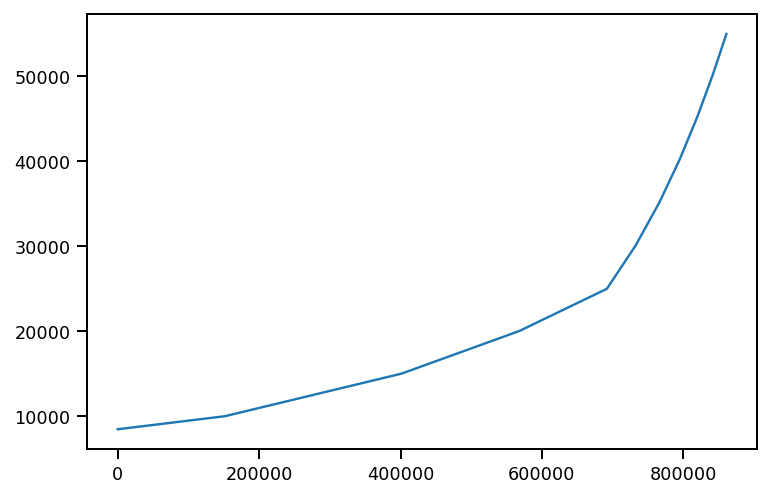

In [81]:
plt.plot(model.wl_native)

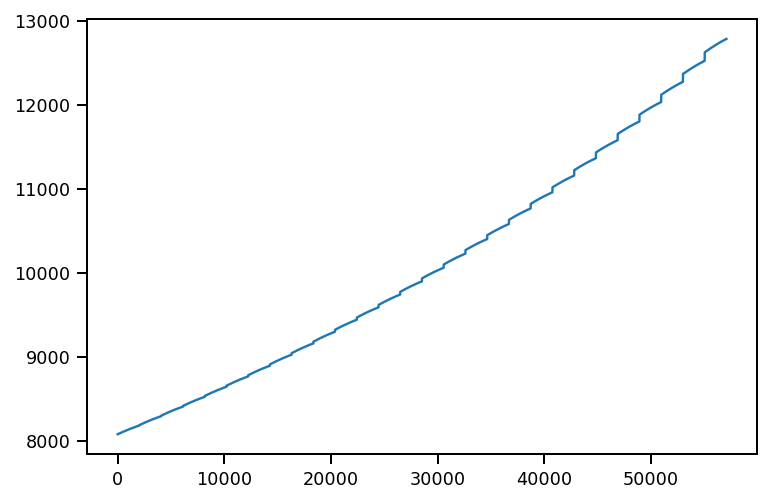

In [82]:
plt.plot(wl)

In [88]:
n_native = len(model.wl_native)

In [124]:
x = wl.unsqueeze(1).cuda()
y = model.wl_native.unsqueeze(0).cuda()


In [126]:
def similarity_matrix(x, y):
    r = torch.mm(x, y)
    # get the diagonal elements
    diag = r.diag().unsqueeze(0)
    diag = diag.expand_as(r)
    # compute the distance matrix
    D = diag + diag.t() - 2*r
    return D.sqrt().argmin(dim=1)

In [127]:
similarity_matrix(x, y)

RuntimeError: CUDA out of memory. Tried to allocate 366.12 GiB (GPU 0; 7.80 GiB total capacity; 37.93 MiB already allocated; 7.02 GiB free; 46.00 MiB reserved in total by PyTorch)

In [93]:
from pykeops.torch import LazyTensor

In [107]:
x_i = LazyTensor(wl.unsqueeze(1).unsqueeze(2).cuda())
y_j = LazyTensor(model.wl_native.unsqueeze(0).unsqueeze(2).cuda())


In [108]:
x_i.shape

(57087, 1)

In [109]:
y_j.shape

(1, 860795)

In [116]:
D_ij = ((x_i - y_j+3.1)**2).argmin(dim=1)

Compiling libKeOpstorchc2af9723df in /home/gully/.cache/pykeops-1.4.1-cpython-38/build-libKeOpstorchc2af9723df:
       formula: ArgMin_Reduction(Square(((Var(0,1,0) - Var(1,1,1)) + Var(2,1,2))),0)
       aliases: Var(0,1,0); Var(1,1,1); Var(2,1,2); 
       dtype  : float64
... Done.


In [112]:
D_ij.shape

torch.Size([57087, 1])

In [ ]:
x_i = LazyTensor( x[:,None,:] )  # x_i.shape = (1e6, 1, 3)
y_j = LazyTensor( y[None,:,:] )  # y_j.shape = ( 1, 2e6,3)

In [121]:
@torch.jit.script
def get_inds(x_i, y_j):
    return ((x_i - y_j)**2).argmin(dim=1)

In [122]:
get_inds(x_i, y_j)

RuntimeError: get_inds() Expected a value of type 'Tensor (inferred)' for argument 'x_i' but instead found type 'LazyTensor'.
Inferred 'x_i' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 0
Value: <pykeops.common.lazy_tensor.LazyTensor object at 0x7f31f8540910>
Declaration: get_inds(Tensor x_i, Tensor y_j) -> (Tensor)
Cast error details: Unable to cast Python instance to C++ type (compile in debug mode for details)

In [120]:
traced_get_inds = torch.jit.trace(get_inds, (x_i, y_j))

RuntimeError: Tracer cannot infer type of (<pykeops.common.lazy_tensor.LazyTensor object at 0x7f31f8540910>, <pykeops.common.lazy_tensor.LazyTensor object at 0x7f31f8540880>)
:Only tensors and (possibly nested) tuples of tensors, lists, or dictsare supported as inputs or outputs of traced functions, but instead got value of type LazyTensor.

In [ ]:
# We can now perform large-scale computations, without memory overflows:
D_ij = ((x_i - y_j)**2).sum(dim=2)  # Symbolic (1e6,2e6,1) matrix of squared distances
K_ij = (- D_ij).exp()               # Symbolic (1e6,2e6,1) Gaussian kernel matrix

In [92]:
indices = [torch.argmin((model.wl_native[i].cuda() - wl.cuda())**2) for i in torch.arange(n_native, dtype=int, device='cuda')]

KeyboardInterrupt: 

In [83]:
torch.topk((model.wl_native.unsqueeze(1) - wl.unsqueeze(0))**2, 1, dim=0, largest=False)

RuntimeError: [enforce fail at CPUAllocator.cpp:65] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 393121633320 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
torch.split_with_sizes()